In [2]:
import os
print("📂 Estoy en:", os.getcwd())

📂 Estoy en: c:\Users\evaru\OneDrive\Escritorio\sismiaio\src\experimentos\entrenamientos\v5_training


In [3]:
import os
os.chdir("../../../..")  # Sube tres niveles hasta llegar a la raíz del proyecto
print("📍 Nueva ubicación:", os.getcwd())

📍 Nueva ubicación: c:\Users\evaru\OneDrive\Escritorio\sismiaio



📊 Dataset combinado: 66 eventos
ES_REAL
0    60
1     6
Name: count, dtype: int64

✅ Modelo entrenado sobre datos REALES + SIMULADOS
MAE: 5.06
RMSE: 1.88
R2: 0.20


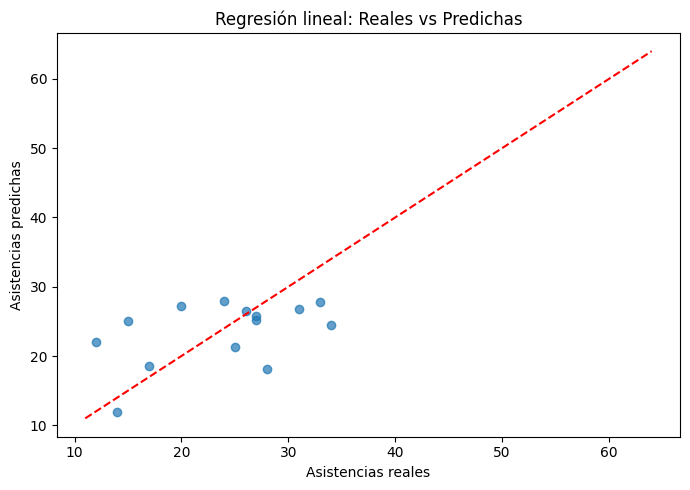


📈 Coeficientes del modelo:
                Variable  Coeficiente
          COSTE_ESTIMADO     6.194754
     TEMPORADA_primavera     3.135867
         TEMPORADA_otoño     2.991688
        TEMPORADA_verano     2.161582
   SEMANA_DENTRO_DEL_MES     0.738544
            PRECIO_MEDIO     0.548302
 TIPO_ACTIVIDAD_only run     0.000000
TIPO_ACTIVIDAD_deportiva    -0.014754
   TIPO_ACTIVIDAD_ludico    -0.150575
          DIA_SEMANA_NUM    -0.321891
                     MES    -0.641003
   TIPO_ACTIVIDAD_ludica    -1.844786
            COLABORACION    -3.736127


In [4]:
# === ENTRENAMIENTO LIMPIO DEL MODELO DE ASISTENCIAS ===

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path

# === CARGA Y FUSIÓN DE DATOS ===
PATH_REAL = Path("data/clean/dataset_modelo.csv")
PATH_SIM = Path("stats/datasets/simulacion_datos_girona.csv")

# Cargar datasets
df_real = pd.read_csv(PATH_REAL, parse_dates=["FECHA_EVENTO"])
df_sim = pd.read_csv(PATH_SIM, parse_dates=["FECHA_EVENTO"])

# Filtrar eventos de pago en GIRONA
filtro_girona_pago = lambda df: df[(df["COMUNIDAD"].str.upper() == "GIRONA") & (df["TIPO_EVENTO"].str.lower() == "pago")]
df_real = filtro_girona_pago(df_real)
df_sim = filtro_girona_pago(df_sim)

# Añadir columna de origen
df_real["ES_REAL"] = 1
df_sim["ES_REAL"] = 0

# Igualar columnas
columnas_comunes = df_real.columns.intersection(df_sim.columns)
df_real = df_real[columnas_comunes]
df_sim = df_sim[columnas_comunes]

# Unir datasets
df = pd.concat([df_real, df_sim], ignore_index=True)

print(f"\n📊 Dataset combinado: {df.shape[0]} eventos")
print(df["ES_REAL"].value_counts())

# === MODELO DE REGRESIÓN ===
features = [
    "COSTE_ESTIMADO",
    "PRECIO_MEDIO",
    "DIA_SEMANA_NUM",
    "MES",
    "SEMANA_DENTRO_DEL_MES",
    "COLABORACION",
    "TEMPORADA",
    "TIPO_ACTIVIDAD"
]
target = "NUM_ASISTENCIAS"

# Preprocesado
X = df[features].copy()
y = df[target].copy()
X = pd.get_dummies(X, columns=["TEMPORADA", "TIPO_ACTIVIDAD"], drop_first=True)

# Dividir y escalar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

# Predicción
y_pred = modelo.predict(X_test_scaled)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) * 0.05
r2 = r2_score(y_test, y_pred)

print("\n✅ Modelo entrenado sobre datos REALES + SIMULADOS")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

# Visualización
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel("Asistencias reales")
plt.ylabel("Asistencias predichas")
plt.title("Regresión lineal: Reales vs Predichas")
plt.tight_layout()
plt.show()

# Coeficientes
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": modelo.coef_
}).sort_values(by="Coeficiente", ascending=False)

print("\n📈 Coeficientes del modelo:")
print(coef_df.to_string(index=False))

Escribiendo, se nos ha colado un tipo de actividad ludico y ludica que es lo mismo y destartalan el modelo "un poco". Por lo tanto vamos a normalizar ese valor. (Unificarlo)

In [6]:
# Normalizar valores de la columna 'TIPO_ACTIVIDAD'
df['TIPO_ACTIVIDAD'] = df['TIPO_ACTIVIDAD'].str.strip().str.lower()

# Corregir posibles duplicados ortográficos
df['TIPO_ACTIVIDAD'] = df['TIPO_ACTIVIDAD'].replace({
    'ludica': 'ludico',
    'only run': 'deportiva'  # Si esto aplica, ajusta según tu lógica
})

Vamos a revisar los outliers por si nos están alterando algo el modelo

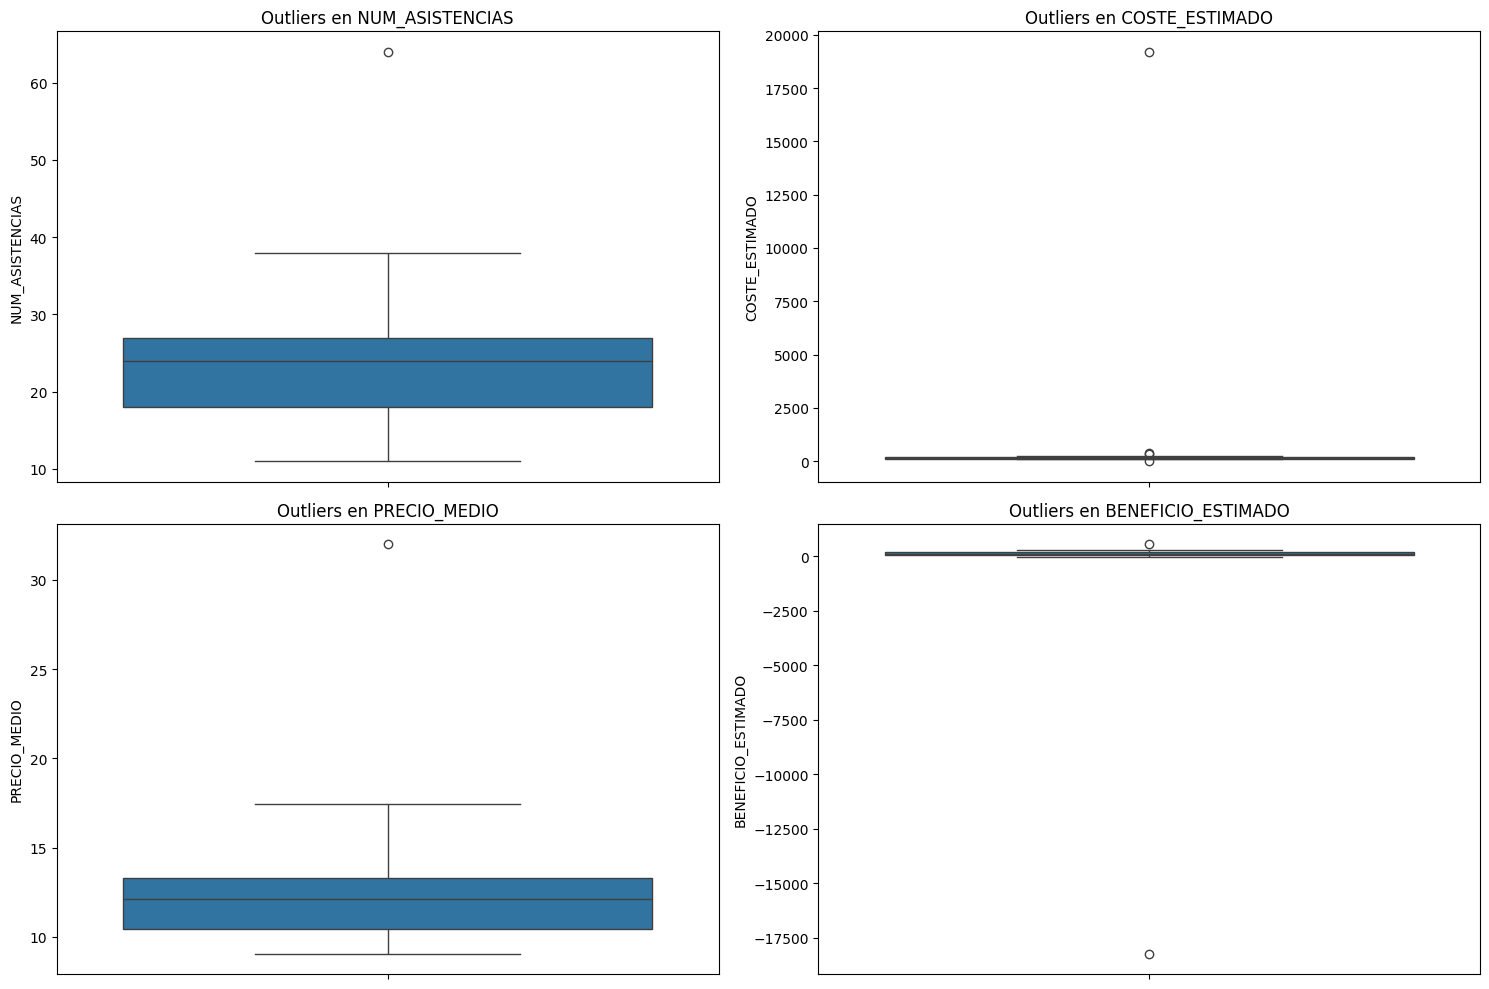

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
variables_a_revisar = ['NUM_ASISTENCIAS', 'COSTE_ESTIMADO', 'PRECIO_MEDIO', 'BENEFICIO_ESTIMADO']

# Gráfico boxplot para detectar valores extremos
plt.figure(figsize=(15, 10))
for i, col in enumerate(variables_a_revisar):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()


In [10]:
# === NORMALIZAR Y LIMPIAR TIPO_ACTIVIDAD ===
df["TIPO_ACTIVIDAD"] = df["TIPO_ACTIVIDAD"].str.strip().str.lower()
df["TIPO_ACTIVIDAD"] = df["TIPO_ACTIVIDAD"].replace({
    "ludica": "ludico",
    "only run": "deportiva"  # Ajusta si tiene sentido para ti
})

# === ELIMINAR OUTLIERS EXAGERADOS ===
filtro = (
    (df["COSTE_ESTIMADO"] <= 1000) &
    (df["BENEFICIO_ESTIMADO"] >= -1000) &
    (df["PRECIO_MEDIO"] <= 30)
)
df = df[filtro].copy()

print(f"✅ Dataset limpio tras eliminar outliers: {df.shape[0]} eventos")


✅ Dataset limpio tras eliminar outliers: 64 eventos



✅ Modelo entrenado con datos LIMPIOS
MAE: 3.96
RMSE: 4.50
R2: 0.39


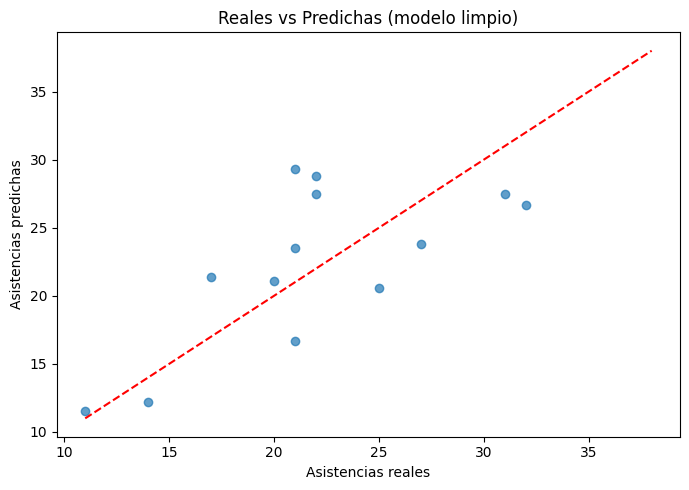

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# === DEFINIR VARIABLES ===
features = [
    "COSTE_ESTIMADO",
    "PRECIO_MEDIO",
    "DIA_SEMANA_NUM",
    "MES",
    "SEMANA_DENTRO_DEL_MES",
    "COLABORACION",
    "TEMPORADA",
    "TIPO_ACTIVIDAD"
]
target = "NUM_ASISTENCIAS"

# === PREPROCESADO ===
X = df[features].copy()
y = df[target].copy()
X = pd.get_dummies(X, columns=["TEMPORADA", "TIPO_ACTIVIDAD"], drop_first=True)

# === DIVISIÓN Y ESCALADO ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === ENTRENAMIENTO ===
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

# === PREDICCIÓN Y MÉTRICAS ===
y_pred = modelo.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n✅ Modelo entrenado con datos LIMPIOS")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

# === VISUALIZACIÓN ===
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel("Asistencias reales")
plt.ylabel("Asistencias predichas")
plt.title("Reales vs Predichas (modelo limpio)")
plt.tight_layout()
plt.show()


In [14]:
# Coeficientes
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": modelo.coef_
}).sort_values(by="Coeficiente", ascending=False)

print("\n📈 Coeficientes del modelo:")
print(coef_df.to_string(index=False))


📈 Coeficientes del modelo:
                Variable  Coeficiente
         TEMPORADA_otoño     3.725029
     TEMPORADA_primavera     2.525513
        TEMPORADA_verano     1.850165
          COSTE_ESTIMADO     0.125297
          DIA_SEMANA_NUM     0.103062
TIPO_ACTIVIDAD_deportiva    -0.098343
   SEMANA_DENTRO_DEL_MES    -0.161723
   TIPO_ACTIVIDAD_ludico    -0.274206
            PRECIO_MEDIO    -0.529477
                     MES    -0.780953
            COLABORACION    -3.013007


Ahora, vamos a comparar el modelo con un random forest.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# === Reutiliza X, y de tu modelo lineal ===

# División del dataset
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# No escalamos para Random Forest
# Entrenamiento
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predicción
y_pred_rf = rf_model.predict(X_test_rf)

# Métricas
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

print("\n🌲 Modelo Random Forest")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R2: {r2_rf:.2f}")



🌲 Modelo Random Forest
MAE: 3.62
RMSE: 4.27
R2: 0.45


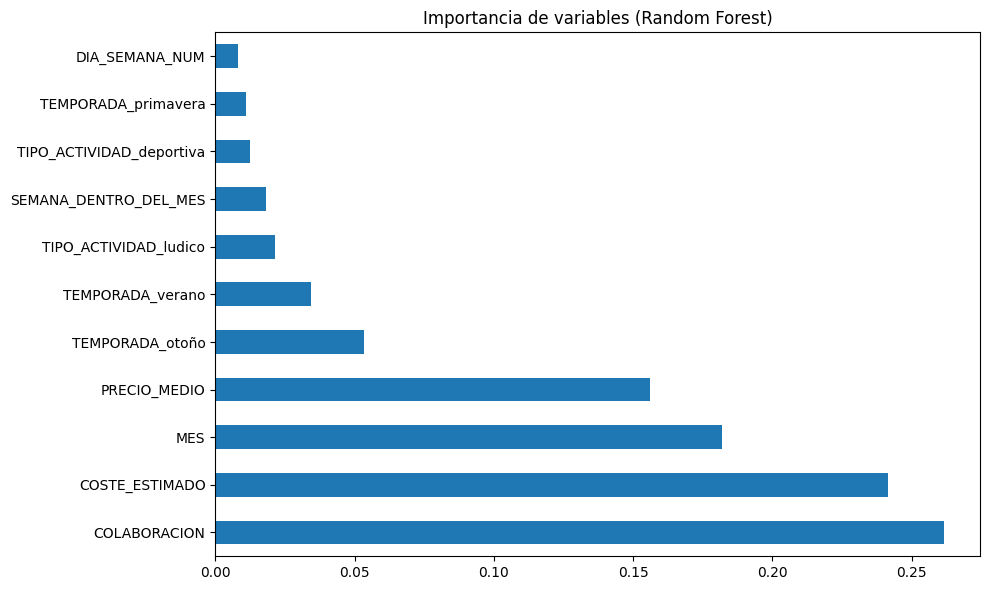

In [16]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title="Importancia de variables (Random Forest)")
plt.tight_layout()
plt.show()

Vamos a integrar la variable temperatura para ver si ha influido en la asistencia

In [26]:
from meteostat import Point, Daily
import pandas as pd
from datetime import datetime

# Coordenadas de Girona
girona = Point(41.9794, 2.8214)

# Fecha del evento
fecha_evento = datetime(2024, 4, 10)

# Obtener datos de ese día
data = Daily(girona, fecha_evento, fecha_evento)
data = data.fetch()

# Mostrar temperatura media si existe
if not data.empty:
    temperatura = data['tavg'].values[0]
    print(f"🌡️ Temperatura media el {fecha_evento.date()}: {temperatura} ºC")
else:
    print(f"⚠️ No hay datos disponibles para {fecha_evento.date()}")


🌡️ Temperatura media el 2024-04-10: 10.8 ºC


In [27]:
from meteostat import Point, Daily
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import time

# Coordenadas de Girona (ajusta si hay eventos en otra ciudad)
punto_estacion = Point(41.9794, 2.8214)  # Girona


df["FECHA_EVENTO"] = pd.to_datetime(df["FECHA_EVENTO"], errors="coerce")

# Crear columna vacía para temperatura
df["TEMPERATURA"] = np.nan

# Recorrer eventos y consultar temperatura
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Añadiendo temperatura"):
    fecha = row["FECHA_EVENTO"]
    if pd.notnull(fecha):
        try:
            data = Daily(punto_estacion, fecha, fecha).fetch()
            if not data.empty and "tavg" in data.columns:
                df.at[idx, "TEMPERATURA"] = data["tavg"].values[0]
            else:
                print(f"⚠️ No hay datos disponibles para {fecha.date()}")
        except Exception as e:
            print(f"❌ Error en {fecha.date()}: {e}")
        time.sleep(1.2)  # cortesía por si se lanzan muchas peticiones seguidas

# Guardar nuevo CSV
df.to_csv("data/clean/dataset_modelo.csv", index=False)
print("✅ Columna TEMPERATURA añadida y guardada.")


Añadiendo temperatura:  91%|█████████ | 58/64 [01:13<00:07,  1.26s/it]

⚠️ No hay datos disponibles para 2025-07-13


Añadiendo temperatura:  92%|█████████▏| 59/64 [01:15<00:06,  1.25s/it]

⚠️ No hay datos disponibles para 2025-08-17


Añadiendo temperatura:  94%|█████████▍| 60/64 [01:16<00:05,  1.25s/it]

⚠️ No hay datos disponibles para 2025-09-07


Añadiendo temperatura:  95%|█████████▌| 61/64 [01:17<00:03,  1.25s/it]

⚠️ No hay datos disponibles para 2025-10-19


Añadiendo temperatura:  97%|█████████▋| 62/64 [01:18<00:02,  1.25s/it]

⚠️ No hay datos disponibles para 2025-11-14


Añadiendo temperatura:  98%|█████████▊| 63/64 [01:20<00:01,  1.25s/it]

⚠️ No hay datos disponibles para 2025-12-14


Añadiendo temperatura: 100%|██████████| 64/64 [01:21<00:00,  1.27s/it]

✅ Columna TEMPERATURA añadida y guardada.


In [29]:
from meteostat import Point, Daily
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import time

# === CARGAR DATOS SIMULADOS ===
df_simulados = pd.read_csv("stats/datasets/simulacion_datos_girona.csv")  # Ajusta la ruta si es distinta

# === COORDENADAS DE GIRONA (Aeropuerto) ===
punto_estacion = Point(41.9794, 2.8214)

# === ASEGURAR FORMATO DE FECHA ===
df_simulados["FECHA_EVENTO"] = pd.to_datetime(df_simulados["FECHA_EVENTO"], errors="coerce")

# === AÑADIR COLUMNA VACÍA DE TEMPERATURA ===
df_simulados["TEMPERATURA"] = np.nan

# === OBTENER TEMPERATURA CON METEOSTAT ===
for idx, row in tqdm(df_simulados.iterrows(), total=len(df_simulados), desc="Simulados: Añadiendo temperatura"):
    fecha = row["FECHA_EVENTO"]
    if pd.notnull(fecha):
        try:
            data = Daily(punto_estacion, fecha, fecha).fetch()
            if not data.empty and "tavg" in data.columns:
                df_simulados.at[idx, "TEMPERATURA"] = data["tavg"].values[0]
            else:
                print(f"⚠️ No hay datos disponibles para {fecha.date()}")
        except Exception as e:
            print(f"❌ Error en {fecha.date()}: {e}")
        time.sleep(1.2)

# === GUARDAR RESULTADO FINAL ===
df_simulados.to_csv("data/clean/simulacion_datos_girona.csv", index=False)
print("✅ Temperatura añadida a eventos simulados.")


Simulados: Añadiendo temperatura:   0%|          | 0/300 [00:00<?, ?it/s]

Simulados: Añadiendo temperatura:  88%|████████▊ | 265/300 [05:29<00:43,  1.25s/it]

⚠️ No hay datos disponibles para 2025-06-22


Simulados: Añadiendo temperatura:  89%|████████▉ | 267/300 [05:31<00:40,  1.24s/it]

⚠️ No hay datos disponibles para 2025-06-25


Simulados: Añadiendo temperatura:  89%|████████▉ | 268/300 [05:32<00:39,  1.24s/it]

⚠️ No hay datos disponibles para 2025-06-20


Simulados: Añadiendo temperatura:  90%|█████████ | 270/300 [05:35<00:37,  1.24s/it]

⚠️ No hay datos disponibles para 2025-07-06


Simulados: Añadiendo temperatura:  90%|█████████ | 271/300 [05:36<00:36,  1.24s/it]

⚠️ No hay datos disponibles para 2025-07-01


Simulados: Añadiendo temperatura:  91%|█████████ | 272/300 [05:37<00:34,  1.24s/it]

⚠️ No hay datos disponibles para 2025-07-13


Simulados: Añadiendo temperatura:  91%|█████████ | 273/300 [05:39<00:33,  1.24s/it]

⚠️ No hay datos disponibles para 2025-07-07


Simulados: Añadiendo temperatura:  91%|█████████▏| 274/300 [05:40<00:32,  1.25s/it]

⚠️ No hay datos disponibles para 2025-07-13


Simulados: Añadiendo temperatura:  92%|█████████▏| 275/300 [05:41<00:31,  1.25s/it]

⚠️ No hay datos disponibles para 2025-08-21


Simulados: Añadiendo temperatura:  92%|█████████▏| 276/300 [05:42<00:30,  1.25s/it]

⚠️ No hay datos disponibles para 2025-08-25


Simulados: Añadiendo temperatura:  92%|█████████▏| 277/300 [05:44<00:28,  1.25s/it]

⚠️ No hay datos disponibles para 2025-08-20


Simulados: Añadiendo temperatura:  93%|█████████▎| 278/300 [05:45<00:27,  1.26s/it]

⚠️ No hay datos disponibles para 2025-08-19


Simulados: Añadiendo temperatura:  93%|█████████▎| 279/300 [05:46<00:26,  1.25s/it]

⚠️ No hay datos disponibles para 2025-08-17


Simulados: Añadiendo temperatura:  93%|█████████▎| 280/300 [05:47<00:24,  1.25s/it]

⚠️ No hay datos disponibles para 2025-09-14


Simulados: Añadiendo temperatura:  94%|█████████▎| 281/300 [05:49<00:24,  1.26s/it]

⚠️ No hay datos disponibles para 2025-09-21


Simulados: Añadiendo temperatura:  94%|█████████▍| 282/300 [05:50<00:22,  1.26s/it]

⚠️ No hay datos disponibles para 2025-09-14


Simulados: Añadiendo temperatura:  94%|█████████▍| 283/300 [05:51<00:21,  1.25s/it]

⚠️ No hay datos disponibles para 2025-09-12


Simulados: Añadiendo temperatura:  95%|█████████▍| 284/300 [05:52<00:19,  1.25s/it]

⚠️ No hay datos disponibles para 2025-09-07


Simulados: Añadiendo temperatura:  95%|█████████▌| 285/300 [05:54<00:18,  1.24s/it]

⚠️ No hay datos disponibles para 2025-10-14


Simulados: Añadiendo temperatura:  95%|█████████▌| 286/300 [05:55<00:17,  1.24s/it]

⚠️ No hay datos disponibles para 2025-10-21


Simulados: Añadiendo temperatura:  96%|█████████▌| 287/300 [05:56<00:16,  1.24s/it]

⚠️ No hay datos disponibles para 2025-10-18


Simulados: Añadiendo temperatura:  96%|█████████▌| 288/300 [05:57<00:14,  1.24s/it]

⚠️ No hay datos disponibles para 2025-10-27


Simulados: Añadiendo temperatura:  96%|█████████▋| 289/300 [05:59<00:13,  1.24s/it]

⚠️ No hay datos disponibles para 2025-10-19


Simulados: Añadiendo temperatura:  97%|█████████▋| 290/300 [06:00<00:12,  1.24s/it]

⚠️ No hay datos disponibles para 2025-11-28


Simulados: Añadiendo temperatura:  97%|█████████▋| 291/300 [06:01<00:11,  1.24s/it]

⚠️ No hay datos disponibles para 2025-11-03


Simulados: Añadiendo temperatura:  97%|█████████▋| 292/300 [06:02<00:09,  1.24s/it]

⚠️ No hay datos disponibles para 2025-11-08


Simulados: Añadiendo temperatura:  98%|█████████▊| 293/300 [06:03<00:08,  1.24s/it]

⚠️ No hay datos disponibles para 2025-11-22


Simulados: Añadiendo temperatura:  98%|█████████▊| 294/300 [06:05<00:07,  1.24s/it]

⚠️ No hay datos disponibles para 2025-11-14


Simulados: Añadiendo temperatura:  98%|█████████▊| 295/300 [06:06<00:06,  1.25s/it]

⚠️ No hay datos disponibles para 2025-12-28


Simulados: Añadiendo temperatura:  99%|█████████▊| 296/300 [06:07<00:04,  1.25s/it]

⚠️ No hay datos disponibles para 2025-12-07


Simulados: Añadiendo temperatura:  99%|█████████▉| 297/300 [06:09<00:03,  1.26s/it]

⚠️ No hay datos disponibles para 2025-12-11


Simulados: Añadiendo temperatura:  99%|█████████▉| 298/300 [06:10<00:02,  1.25s/it]

⚠️ No hay datos disponibles para 2025-12-23


Simulados: Añadiendo temperatura: 100%|█████████▉| 299/300 [06:11<00:01,  1.25s/it]

⚠️ No hay datos disponibles para 2025-12-14


Simulados: Añadiendo temperatura: 100%|██████████| 300/300 [06:12<00:00,  1.24s/it]

✅ Temperatura añadida a eventos simulados.


📊 Dataset combinado tras limpieza: 112 eventos

✅ Modelo entrenado solo con eventos que tienen temperatura:
MAE: 3.29
RMSE: 4.12
R2: 0.50

📈 Coeficientes del modelo:
                    Variable  Coeficiente
9           TEMPORADA_verano     4.947044
8        TEMPORADA_primavera     4.451778
7            TEMPORADA_otoño     4.345564
10  TIPO_ACTIVIDAD_deportiva     0.338497
2             DIA_SEMANA_NUM     0.248275
1               PRECIO_MEDIO     0.130386
4      SEMANA_DENTRO_DEL_MES     0.082251
0             COSTE_ESTIMADO    -0.005995
11     TIPO_ACTIVIDAD_ludico    -0.240228
3                        MES    -0.447068
6                TEMPERATURA    -2.419406
5               COLABORACION    -3.005905


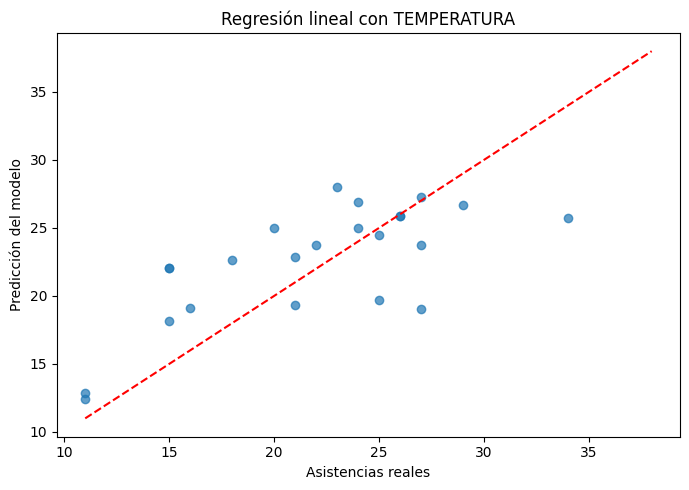

In [32]:
# === CARGAR LOS DOS DATAFRAMES NUEVOS ===
df_reales = pd.read_csv("data/clean/dataset_modelo.csv")  
df_simulados = pd.read_csv("data/clean/simulacion_datos_girona.csv")

# === AÑADIR IDENTIFICADOR DE ORIGEN ===
df_reales["ES_REAL"] = 1
df_simulados["ES_REAL"] = 0

# === UNIR Y FILTRAR ===
df_combined = pd.concat([df_reales, df_simulados], ignore_index=True)

# FILTRAMOS eventos de pago y que sí tengan temperatura
df_combined = df_combined[
    (df_combined["TIPO_EVENTO"] == "pago") &
    (df_combined["TEMPERATURA"].notnull())
].copy()

print(f"📊 Dataset combinado tras limpieza: {df_combined.shape[0]} eventos")

# === VARIABLES ===
features = [
    "COSTE_ESTIMADO", "PRECIO_MEDIO", "DIA_SEMANA_NUM", "MES",
    "SEMANA_DENTRO_DEL_MES", "COLABORACION", "TEMPORADA",
    "TIPO_ACTIVIDAD", "TEMPERATURA"
]
target = "NUM_ASISTENCIAS"

# === ENCODING Y MODELO ===
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

df_model = df_combined[features + [target]].copy()
df_model = pd.get_dummies(df_model, columns=["TEMPORADA", "TIPO_ACTIVIDAD"], drop_first=True)

X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
y_pred = modelo.predict(X_test_scaled)

# === RESULTADOS ===
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n✅ Modelo entrenado solo con eventos que tienen temperatura:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

# === IMPORTANCIA DE VARIABLES ===
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": modelo.coef_
}).sort_values(by="Coeficiente", ascending=False)

print("\n📈 Coeficientes del modelo:")
print(coef_df)

# === PLOT ===
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel("Asistencias reales")
plt.ylabel("Predicción del modelo")
plt.title("Regresión lineal con TEMPERATURA")
plt.tight_layout()
plt.show()


📈 Coeficientes del modelo de regresión lineal:
                    Variable  Coeficiente
9           TEMPORADA_verano     4.947044
8        TEMPORADA_primavera     4.451778
7            TEMPORADA_otoño     4.345564
10  TIPO_ACTIVIDAD_deportiva     0.338497
2             DIA_SEMANA_NUM     0.248275
1               PRECIO_MEDIO     0.130386
4      SEMANA_DENTRO_DEL_MES     0.082251
0             COSTE_ESTIMADO    -0.005995
11     TIPO_ACTIVIDAD_ludico    -0.240228
3                        MES    -0.447068
6                TEMPERATURA    -2.419406
5               COLABORACION    -3.005905


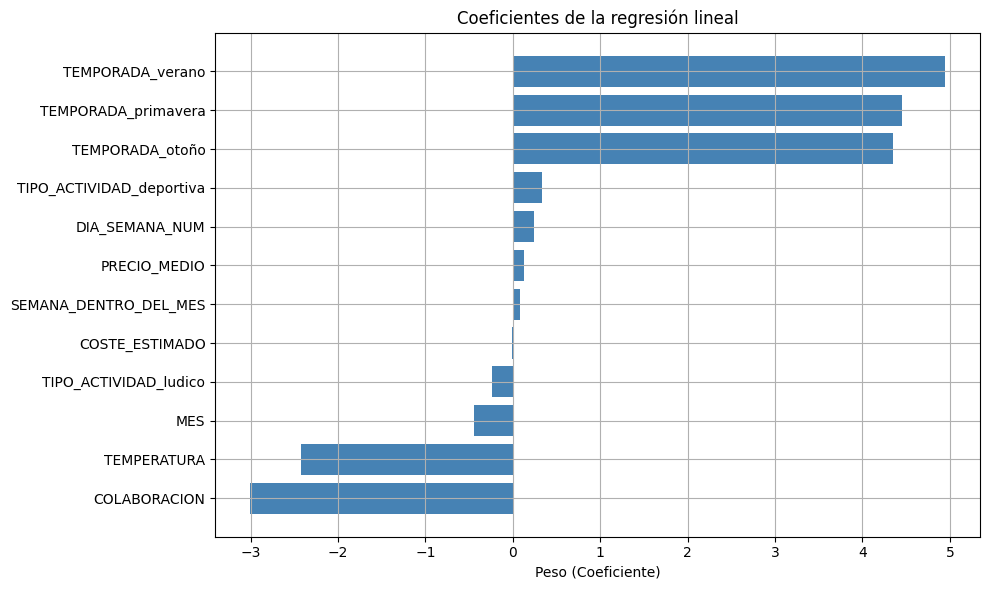

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Obtener coeficientes con nombre de variables
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": modelo.coef_
}).sort_values(by="Coeficiente", ascending=False)

# Mostrar en consola
print("📈 Coeficientes del modelo de regresión lineal:")
print(coef_df)

# Visualizar como gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Variable"], coef_df["Coeficiente"], color='steelblue')
plt.title("Coeficientes de la regresión lineal")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()  # Para que el más alto aparezca arriba
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# === Cargar dataset con columna TEMPERATURA incluida ===
df = pd.read_csv("data/clean/dataset_modelo.csv")

# === Filtrar registros con temperatura disponible ===
df = df[df["TEMPERATURA"].notna()].copy()

# === Variables predictoras ===
features = [
    "COSTE_ESTIMADO",
    "PRECIO_MEDIO",
    "DIA_SEMANA_NUM",
    "MES",
    "SEMANA_DENTRO_DEL_MES",
    "COLABORACION",
    "TEMPORADA",
    "TIPO_ACTIVIDAD",
    "TEMPERATURA"  # <- NUEVA variable
]

target = "NUM_ASISTENCIAS"

# === One-hot encoding de variables categóricas ===
df_model = df[features + [target]].copy()
df_model = pd.get_dummies(df_model, columns=["TEMPORADA", "TIPO_ACTIVIDAD"], drop_first=True)

X = df_model.drop(columns=[target])
y = df_model[target]

# === Split de entrenamiento/test ===
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# === Entrenar modelo ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# === Predicción ===
y_pred_rf = rf_model.predict(X_test_rf)

# === Métricas ===
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

print("\n🌲 Modelo Random Forest con temperatura")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R2: {r2_rf:.2f}")



🌲 Modelo Random Forest con temperatura
MAE: 3.92
RMSE: 4.58
R2: 0.02


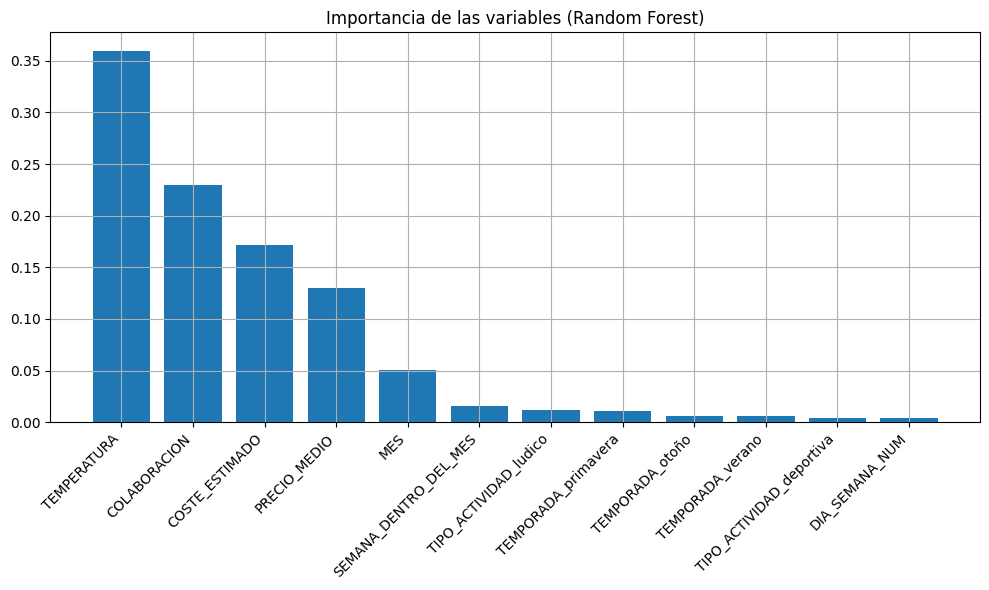

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Visualización
plt.figure(figsize=(10, 6))
plt.title("Importancia de las variables (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()



✅ Modelo sin TEMPORADA ni MES
MAE: 4.51
RMSE: 5.73
R2: -0.53


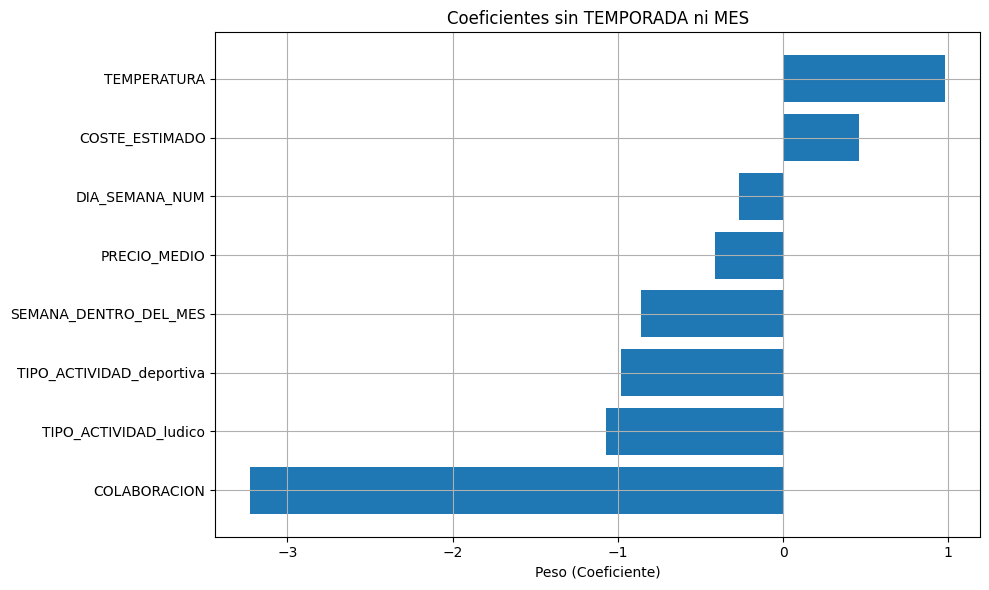

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Eliminar columnas TEMPORADA_* y MES
X_reducido = X.drop(columns=[col for col in X.columns if col.startswith("TEMPORADA") or col == "MES"])

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_reducido, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelo_simple = LinearRegression()
modelo_simple.fit(X_train_scaled, y_train)

# Predicción y métricas
y_pred = modelo_simple.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) **0.5
r2 = r2_score(y_test, y_pred)

print("\n✅ Modelo sin TEMPORADA ni MES")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

# Coeficientes
coef_df = pd.DataFrame({
    "Variable": X_reducido.columns,
    "Coeficiente": modelo_simple.coef_
}).sort_values(by="Coeficiente", ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Variable"], coef_df["Coeficiente"])
plt.title("Coeficientes sin TEMPORADA ni MES")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


Aunque "Temperatura" tenga sentido físico, no basta por sí sola para representar el patrón temporal. Las variables como MES, TEMPORADA o incluso DIA_SEMANA_NUM están metiendo estructura cíclica que TEMPERATURA no puede sustituir completamente (además, la temp. faltaba en muchos eventos recientes).

Vamos a ver el modelo cómo funciona con las variables y unicamente para los datos reales. 


✅ Modelo de regresión con eventos reales + temperatura
MAE: 10.63
RMSE: 10.89
R2: -17.98


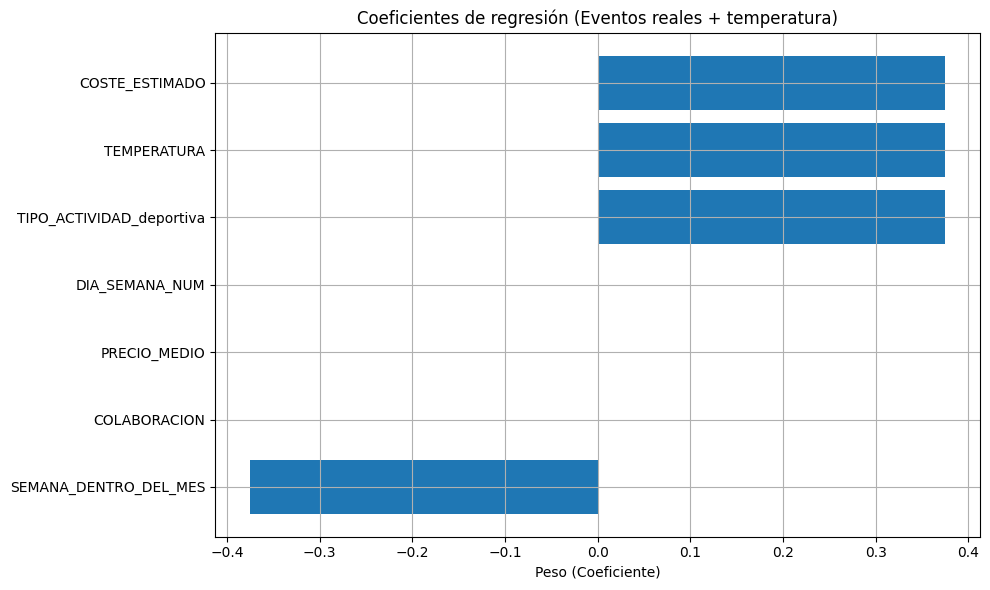

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# === Cargar datos ===
df = pd.read_csv("data/clean/dataset_modelo.csv")

# === Filtrar solo eventos reales con temperatura disponible ===
df_reales_temp = df[(df["ES_REAL"] == 1) & (df["TEMPERATURA"].notnull())]

# === Variables ===
features = [
    "COSTE_ESTIMADO",
    "PRECIO_MEDIO",
    "DIA_SEMANA_NUM",
    "SEMANA_DENTRO_DEL_MES",
    "COLABORACION",
    "TIPO_ACTIVIDAD",
    "TEMPERATURA"
]
target = "NUM_ASISTENCIAS"

# === One-hot encoding ===
df_model = df_reales_temp[features + [target]].copy()
df_model = pd.get_dummies(df_model, columns=["TIPO_ACTIVIDAD"], drop_first=True)

# === Preparar X e y ===
X = df_model.drop(columns=[target])
y = df_model[target]

# === Evitar problemas de test demasiado pequeño ===
if len(df_model) < 10:
    test_size = 0.4  # más grande para que al menos haya 2 en test
else:
    test_size = 0.2

# === División y escalado ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Entrenamiento ===
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

# === Predicción y métricas ===
y_pred = modelo.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n✅ Modelo de regresión con eventos reales + temperatura")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

# === Coeficientes ===
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": modelo.coef_
}).sort_values(by="Coeficiente", ascending=False)

# === Visualización ===
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Variable"], coef_df["Coeficiente"])
plt.title("Coeficientes de regresión (Eventos reales + temperatura)")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


Vamos a ver si podemos introducir la variable dias de publicacion en Instagram del evento, al modelo. 

In [48]:
import requests
import pandas as pd
from datetime import datetime
import os
import time

ACCESS_TOKEN = "EAAJg1EXrT80BO42KgisKKLP5gqsKmtn6VUsL7PZCnra3uZCDtlMfTTvW4Lsxlq0PWNlyz1hMpL2rZB2k3QZCkpNSJVe3UATadn7725xc4w869ZCqQ4Uj20mqjjb4fWR81i9LrAxmkvzQqgdvW0oAcjwmSZC9b53s7jHxPQ4vSUujRgBeYOXgZDZD"
IG_USER_ID = "17841458252704780"
BASE_URL = f"https://graph.facebook.com/v22.0"
OUTPUT_FILE = "data/clean/posts_instagram.csv"

def get_recent_posts(limit=20):
    url = f"{BASE_URL}/{IG_USER_ID}/media"
    params = {
        "fields": "id,caption,timestamp,media_type,media_url,permalink",
        "access_token": ACCESS_TOKEN,
        "limit": limit
    }
    res = requests.get(url, params=params)
    res.raise_for_status()
    return res.json().get("data", [])

def get_post_metrics(media_id):
    url = f"{BASE_URL}/{media_id}/insights"
    params = {
        "metric": "reach,likes,comments,shares,saved,total_interactions",
        "access_token": ACCESS_TOKEN
    }
    res = requests.get(url, params=params)
    res.raise_for_status()
    metrics = {m["name"]: m["values"][0]["value"] for m in res.json().get("data", [])}
    return metrics

def fetch_and_save_posts(limit=20):
    posts = get_recent_posts(limit)
    all_data = []

    for post in posts:
        time.sleep(0.5)  # Para no quemar la API
        metrics = get_post_metrics(post["id"])
        post_data = {
            "media_id": post["id"],
            "fecha_post": post["timestamp"],
            "caption": post.get("caption", ""),
            "media_type": post["media_type"],
            "media_url": post["media_url"],
            "permalink": post["permalink"]
        }
        post_data.update(metrics)
        all_data.append(post_data)

    df = pd.DataFrame(all_data)
    df["fecha_post"] = pd.to_datetime(df["fecha_post"])
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"✅ Guardado en {OUTPUT_FILE} ({len(df)} posts)")

if __name__ == "__main__":
    print("📸 Extrayendo posts y métricas de Instagram...")
    try:
        fetch_and_save_posts(limit=50)  # Puedes subir el límite si quieres más posts
    except Exception as e:
        print(f"❌ Error durante la extracción: {e}")



📸 Extrayendo posts y métricas de Instagram...
✅ Guardado en data/clean/posts_instagram.csv (50 posts)


In [58]:
import pandas as pd

# === CARGA DE DATOS ===
df_eventos = pd.read_csv("data/clean/dataset_modelo.csv")
df_posts = pd.read_csv("data/clean/posts_instagram.csv")

# === Normalización de fechas ===
df_eventos["FECHA_EVENTO"] = pd.to_datetime(df_eventos["FECHA_EVENTO"], errors="coerce")
df_posts["fecha_post"] = pd.to_datetime(df_posts["fecha_post"], errors="coerce")

# Eliminar zona horaria para evitar errores al comparar
df_eventos["FECHA_EVENTO"] = df_eventos["FECHA_EVENTO"].dt.tz_localize(None)
df_posts["fecha_post"] = df_posts["fecha_post"].dt.tz_localize(None)

# === Diagnóstico: cuántos eventos tienen algún post que mencione su nombre ===
match_count = 0
for i, evento in df_eventos.iterrows():
    nombre = evento["NOMBRE_EVENTO"]
    posts_relacionados = df_posts[df_posts["caption"].str.contains(nombre, case=False, na=False)]
    if not posts_relacionados.empty:
        match_count += 1

print(f"📌 Eventos con algún post que mencione su nombre: {match_count} de {len(df_eventos)}")

# === Inicializar nueva columna ===
df_eventos["DIF_DIAS_PUBLICACION"] = None

# === Asignar diferencia de días con el post más cercano anterior ===
for i, evento in df_eventos.iterrows():
    nombre_evento = evento["NOMBRE_EVENTO"]
    fecha_evento = evento["FECHA_EVENTO"]

    posts_relacionados = df_posts[df_posts["caption"].str.contains(nombre_evento, case=False, na=False)]

    # Filtramos solo los anteriores al evento
    posts_anteriores = posts_relacionados[posts_relacionados["fecha_post"] < fecha_evento]

    if not posts_anteriores.empty:
        post_mas_cercano = posts_anteriores.iloc[(fecha_evento - posts_anteriores["fecha_post"]).abs().argsort()].iloc[0]
        diferencia_dias = (fecha_evento - post_mas_cercano["fecha_post"]).days
        df_eventos.at[i, "DIF_DIAS_PUBLICACION"] = diferencia_dias

# === Guardar dataset actualizado ===
df_eventos.to_csv("data/clean/dataset_modelo.csv", index=False)
print("✅ Columna DIF_DIAS_PUBLICACION añadida y dataset guardado.")


📌 Eventos con algún post que mencione su nombre: 1 de 64
✅ Columna DIF_DIAS_PUBLICACION añadida y dataset guardado.
